In [1]:
import cv2
import scipy
import os
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from functools import lru_cache
import torch
from datetime import datetime
import shutil
%matplotlib inline

###Video path

In [ ]:
path = 'botany360.mp4'

##Baseline

###Sharpness kernel

In [ ]:
sharp = np.array((
	[0, -1, 0],
	[-1, 5, -1],
	[0, -1, 0]))

###Baseline algorithm

In [ ]:
def Lanczoz_method(vid_path):
  video = cv2.VideoCapture(vid_path)

  success, image = video.read()
  count = 0
  video_out1 = cv2.VideoWriter('upscaled_cool.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30.0, (2 * image.shape[1], 2 * image.shape[0]))

  while success:
    success,image = video.read()
    if count <= 2:
      cv2.imwrite('frame' + str(count) +".png", image)
    if success:
      frame = cv2.resize(image, (2 *image.shape[1], 2 * image.shape[0]), cv2.INTER_LANCZOS4)
      frame = cv2.filter2D(src=frame, ddepth=-1, kernel=sharp)
      video_out1.write(frame)
    count += 1
  video_out1.release()
  return count


In [ ]:
Lanczoz_method(path)

360

## I like to move it, move it

In [ ]:
img0 = cv2.cvtColor(cv2.imread('frame0.png'), cv2.COLOR_BGR2GRAY)
img1 = cv2.cvtColor(cv2.imread('frame1.png'), cv2.COLOR_BGR2GRAY)

def box_to_box(A, B, accurate = False):

  A = A.astype(np.int32)
  B = B.astype(np.int32)
  sum_sq = (A*A).sum()


  box = cv2.boxFilter(B*B, ddepth = -1, ksize = A.shape, normalize = False)

  corr = scipy.signal.correlate2d(B, A, 'same')
  res = box-2*corr+sum_sq

  min_ind = np.unravel_index(np.argmin(res), res.shape)

  final_y =  (min_ind[0] - B.shape[0]//2)
  final_x =  (min_ind[1] - B.shape[1]//2)

  if accurate:
    z = res[max(0, min_ind[0] - 1) : min_ind[0] + 2, max(0, min_ind[1] - 1) : min_ind[1] + 2]
    x = np.arange(z.shape[1]) - 1
    y = np.arange(z.shape[0]) - 1
    
    kx, ky = 2,2
    if z.shape != (3,3):
      kx, ky = 1,1

    f = scipy.interpolate.RectBivariateSpline(y, x, z, kx=kx, ky=ky)

    y_new = np.linspace(-1, 1, 100)
    x_new = np.linspace(-1, 1, 100) 
    z_new = f(y_new, x_new)

    abs_min_y, abs_min_x = np.unravel_index(np.argmin(z_new), z_new.shape)

    final_x += x_new[abs_min_x]
    final_y += y_new[abs_min_y]

  return final_y, final_x


def image_to_image(img0, img1, wind_a = 3, wind_b = 5): # only odd window sizes
  mask = np.ndarray((img0.shape[0], img0.shape[1], 2))

  for y in range(img0.shape[0]):
    for x in range(img0.shape[1]):
      A = img0[max(y - wind_a//2, 0) : y + wind_a//2 + 1, max(x - wind_a//2, 0) : x + wind_a//2 + 1]
      B = img1[max(y - wind_b//2, 0) : y + wind_b//2 + 1, max(x - wind_b//2, 0) : x + wind_b//2 + 1]
      res_y, res_x = box_to_box(A, B, accurate = 1)

      if y == img0.shape[0] - 1:
        res_y -= 1
      if x == img0.shape[1] - 1:
        res_x -= 1

      mask[y,x] = res_y, res_x

  return mask

# Motion Robustness


In [ ]:
def get_std_mask(frame: torch.Tensor, use_gpu = False):
    """
    Calculate the std mask of frame for robustness mask calculation
    """
    # print(f"Start of calculating of std mask: {datetime.now().time()}")

    number_tiles = 9

    box_kernel = torch.tensor([[1,1,1],[1,1,1],[1,1,1]]).type(torch.float32)
    if use_gpu:
        box_kernel=box_kernel.cuda()
    
    frame_changed = frame.unsqueeze(0).unsqueeze(0)
    box_kernel = box_kernel.unsqueeze(0).unsqueeze(0)
    mean_mask = torch.nn.functional.conv2d(frame_changed, box_kernel/9, padding='same')
    square_mask = torch.nn.functional.conv2d((frame_changed*frame_changed), box_kernel, padding = 'same')

    std_mask = torch.sqrt((square_mask - number_tiles * mean_mask * mean_mask)/(number_tiles - 1))
    std_mask = std_mask.reshape(frame.shape)

    # print(f"End of calculating of std mask: {datetime.now().time()}")
    
    return std_mask

In [ ]:
def motion_robustness(base_frame: torch.Tensor, next_frame: torch.Tensor, use_gpu = False):
    """
    Calculate robustness mask for the algorithm
    """
    # print(f"Start of calculating of motion robustness mask: {datetime.now().time()}")
    
    default_slope = 12
    moved_slope = 2
    default_intercept = 0

    base_frame = base_frame.type(torch.float32)
    next_frame = next_frame.type(torch.float32)

    if use_gpu:
        base_frame = base_frame.cuda()
        next_frame = next_frame.cuda()
    
    # Calculate difference of colors between frames and
    # std of colors of pixels in 3x3 area for base frame

    difference_mask = next_frame - base_frame
    std_mask = get_std_mask(base_frame, use_gpu)
    
    std_mask[torch.isclose(difference_mask, torch.tensor(0).float())] = 1
    r_mask = default_slope*torch.exp(-(difference_mask*difference_mask)/(std_mask*std_mask)) + default_intercept
    
    # print(f"End of calculating of motion robustness mask: {datetime.now().time()}")

    return r_mask

# Kernel Reconstruction

In [ ]:
def torch_photo(path):
  """
  Function to get np array of image with its path
  """
  return torch.from_numpy(cv2.imread(path).astype('int16'))

In [ ]:
def decimate_frame(frame: torch.Tensor):
  """
  Decimating the image - making it twice smaller and grayscale
  """
  # print(f"Decimating the frame: {datetime.now().time()}")

  # Extract the individual color channels
  red_channel = frame[:, :, 0].type(torch.float32)
  green_channel = frame[:, :, 1].type(torch.float32)
  blue_channel = frame[:, :, 2].type(torch.float32)

  # Combine the color channels to create 3 channels for red, green and blue
  return red_channel[::2, ::2], (green_channel[1::2,::2] + green_channel[::2,1::2])/2, blue_channel[1::2,1::2]

In [ ]:
def grad_struct_eigs(frame: torch.Tensor, use_gpu = False):
  """
  Calculating eigenvalues and eigenvectors of Bayer quad matrix with use of 
  gradient structure tensor analysis
  """
  # Calculate gradients of the decimated frame using Sobel filters
  kernel1 = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32)
  kernel2 = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32)
  if use_gpu:
    kernel1 = kernel1.cuda()
    kernel2 = kernel2.cuda()
  grad_x = torch.nn.functional.conv2d(frame.unsqueeze(0).unsqueeze(0), kernel1.unsqueeze(0).unsqueeze(0), padding=1)
  grad_y = torch.nn.functional.conv2d(frame.unsqueeze(0).unsqueeze(0), kernel2.unsqueeze(0).unsqueeze(0), padding=1)

  # Calculate structure tensor components
  gradient_xx = grad_x**2
  gradient_yy = grad_y**2
  gradient_xy = grad_x * grad_y

  # Calculate eigenvalues of the structure tensor
  eigenvalues, eigenvectors = torch.linalg.eig(torch.stack([gradient_yy, gradient_xy, gradient_xy, gradient_xx], dim=-1).view(-1, 2, 2))
  
  # Sorting of eigenvalues
  eigenvalues, indices = torch.sort(eigenvalues.real, dim = 1, descending = True)
  eigenvectors = torch.take_along_dim(eigenvectors, indices[:, None, :], dim=2)

  return (eigenvalues.real, eigenvectors.real)

In [ ]:
def get_k_matrix(eigenvalues: torch.Tensor, use_gpu = False):
  """
  Getting k matrix with use of two eigenvalues, that we get for some quad pixel.
  """
  k_detail = 0.25
  k_denoise = 3.0
  D_th = 0.005
  D_tr = 0.01
  k_stretch = 4
  k_shrink = 2
  A = torch.tensor((), dtype = torch.float32).new_ones((eigenvalues.shape[0]))
  if use_gpu:
    A = A.cuda()

  mask = torch.sum(eigenvalues, dim = 1) != 0
  A[mask] += (torch.sqrt(-torch.diff(eigenvalues[mask], dim = 1).T / torch.sum(eigenvalues[mask], dim = 1))).flatten()

  D = torch.clamp(1 - (torch.sqrt(eigenvalues[:,0]) / D_tr) + D_th, min = 0, max = 1)
  k_1_hat = k_detail * (k_stretch * A)
  k_2_hat = k_detail / (k_shrink * A)
  k_1 = ((1 - D) * k_1_hat + D * k_detail * k_denoise) ** 2
  k_2 = ((1 - D) * k_2_hat + D * k_detail * k_denoise) ** 2
  
  result = torch.tensor((), dtype=torch.float32).new_zeros((A.shape[0], 2, 2))
  result[:,0,0] = k_1
  result[:,1,1] = k_2
  return result

In [ ]:
def kernel_covariance(frame: torch.Tensor, use_gpu = False):
  """
  Calculating kernel covariance matrix for single frame
  """
  if use_gpu:
    frame = frame.cuda()
  red, green, blue = decimate_frame(frame)

  # Get eigenvalues and eigenvectors of gradients 
  # with gradient structure tensor analysis 
  r_eigenvalues, r_eigenvectors = grad_struct_eigs(red, use_gpu)
  g_eigenvalues, g_eigenvectors = grad_struct_eigs(green, use_gpu)
  b_eigenvalues, b_eigenvectors = grad_struct_eigs(blue, use_gpu)
  
  r_k_matrices = get_k_matrix(r_eigenvalues, use_gpu).type(torch.float32)
  g_k_matrices = get_k_matrix(g_eigenvalues, use_gpu).type(torch.float32)
  b_k_matrices = get_k_matrix(b_eigenvalues, use_gpu).type(torch.float32)

  if use_gpu:
    r_kernel_covariance = r_eigenvectors.float()@r_k_matrices.float().cuda()@torch.transpose(r_eigenvectors, 1, 2)
    g_kernel_covariance = g_eigenvectors.float()@g_k_matrices.float().cuda()@torch.transpose(g_eigenvectors, 1, 2)
    b_kernel_covariance = b_eigenvectors.float()@b_k_matrices.float().cuda()@torch.transpose(b_eigenvectors, 1, 2)
  else:
    r_kernel_covariance = r_eigenvectors.float()@r_k_matrices.float()@torch.transpose(r_eigenvectors, 1, 2)
    g_kernel_covariance = g_eigenvectors.float()@g_k_matrices.float()@torch.transpose(g_eigenvectors, 1, 2)
    b_kernel_covariance = b_eigenvectors.float()@b_k_matrices.float()@torch.transpose(b_eigenvectors, 1, 2)

  # Reshape into rectangular
  decimated_shape = list(red.size())
  r_kernel_covariance = r_kernel_covariance.reshape([2, 2] + decimated_shape)
  g_kernel_covariance = g_kernel_covariance.reshape([2, 2] + decimated_shape)
  b_kernel_covariance = b_kernel_covariance.reshape([2, 2] + decimated_shape)

  return r_kernel_covariance, g_kernel_covariance, b_kernel_covariance

In [ ]:
def merge(frame, kernel: tuple[torch.Tensor], robustness, numerator, denominator, scale=1):
  """
  Merging of certain kernel and robustness mask into numerator
  and denominator tensors
  """
  # Frame padding
  frame_padded = torch.nn.functional.pad(frame, [0,0,1,1,1,1], value=0)

  # Robustness
  robustness = robustness.reshape(-1)

  # Cov. Kernel
  red, green, blue = kernel

  red = torch.nn.functional.interpolate(red, scale_factor = 2*scale, mode = 'bilinear').reshape((-1,2,2))
  green = torch.nn.functional.interpolate(green, scale_factor = 2*scale, mode = 'bilinear').reshape((-1,2,2))
  blue = torch.nn.functional.interpolate(blue, scale_factor = 2*scale, mode = 'bilinear').reshape((-1,2,2))

  red[torch.isclose(torch.det(red), torch.tensor(0).float())] = torch.tensor([[1,0],[0,1]]).float()
  green[torch.isclose(torch.det(green), torch.tensor(0).float())] = torch.tensor([[1,0],[0,1]]).float()
  blue[torch.isclose(torch.det(blue), torch.tensor(0).float())] = torch.tensor([[1,0],[0,1]]).float()

  covs = torch.tensor((), dtype = torch.float32).new_empty((3, red.shape[0], 2, 2))
  covs[0] = torch.inverse(red)
  covs[1] = torch.inverse(green)
  covs[2] = torch.inverse(blue)

  for chan in range(3):
    for i in range(-1,2):
      for j in range(-1,2):
        d = torch.tensor([[i],[j]]).float()
        weight = torch.exp(-1/2*d.T@covs[chan]@d).reshape(-1)
        weight[weight > 1] = 0
        denominator[:,chan] += robustness * weight
        numerator[:,chan] += robustness * weight * frame_padded[1+i:frame_padded.shape[0]-1+i, 1+j:frame_padded.shape[1]-1+j, chan]\
          .reshape(-1)
  
  return numerator, denominator

## Main process

$C(x,y) = \frac{\sum_n\sum_i c_{n,i}\cdot w_{n,i} \cdot R_n }{\sum_n\sum_iw_{n,i} \cdot R_n }$ \\


In [ ]:
def frame_computation(upscale_frame, helping_frames):
  """
  Computation of single frame for the whole video.
  Create two main tensors with numerator and denominator of above matrix,
  which would be divided in the end of the operation."""
  # Create empty numerator and denominator objects
  y, x, c = upscale_frame.shape
  numerator = torch.zeros([y,x,c]).float().reshape((-1,3))
  denominator = torch.zeros([y,x,c]).float().reshape((-1,3))

  for frame in helping_frames:
    kernel = kernel_covariance(frame)

    gray_frame = (frame[:,:,0] + frame[:,:,1] + frame[:,:,2])/3
    robustness = motion_robustness(gray_frame, gray_frame)

    numerator, denominator = merge(frame, kernel, robustness, numerator, denominator)

  kernel = kernel_covariance(upscale_frame)
  gray_frame = (upscale_frame[:,:,0] + upscale_frame[:,:,1] + upscale_frame[:,:,2])/3
  robustness = motion_robustness(gray_frame, gray_frame)
  y, x, c = upscale_frame.shape

  numerator, denominator = merge(upscale_frame, kernel, robustness, numerator, denominator)
    
  return (numerator / denominator).reshape(upscale_frame.shape).type(torch.uint8)

  # Return the frame
  return frame_accumulation_numerator


In [ ]:
ups = frame_computation(torch_photo('frame1.png'), [torch_photo('frame0.png'), torch_photo('frame2.png')])

Decimating the frame: 05:09:14.650673
Decimating the frame: 05:09:14.977749
Decimating the frame: 05:09:15.235401


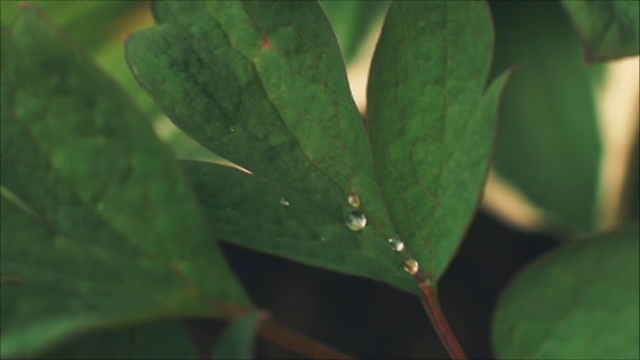

In [ ]:
cv2_imshow(ups_7.numpy())

## Create upscaled video from source

In [ ]:
def cache_video(path):
    if not os.path.exists('cache'):
        os.mkdir('cache')
    video = cv2.VideoCapture(path)
    frameNr = 0
    
    while (True):
        success, frame = video.read()
        if success:
            cv2.imwrite(f'cache/frame_{frameNr}.png', frame)
        else:
            break
        frameNr = frameNr+1
        
    video.release()

    return frameNr

In [ ]:
def compile_video(input_path, output_path, window_size=3):
    if not os.path.exists('result'):
        os.mkdir('result')

    num_of_frames = cache_video(input_path)

    for frame_number in tqdm(range(num_of_frames)):
        help_frames_numbers = [i for i in range(frame_number - (window_size - 1) // 2, frame_number + window_size // 2) if (i != frame_number and i >= 0 and i < num_of_frames)]
        frame = frame_computation(torch_photo(f'cache/frame_{frame_number}.png'), [torch_photo(f'cache/frame_{help_frames_number}.png') for help_frames_number in help_frames_numbers])
        cv2.imwrite(f'result/frame_{frame_number}.png', frame.numpy())

    video_out1 = cv2.VideoWriter(f'{output_path}', cv2.VideoWriter_fourcc(*'mp4v'), 30.0, (frame.shape[1], frame.shape[0]))
    
    for frame_number in range(num_of_frames):
        video_out1.write(cv2.imread(f'result/frame_{frame_number}.png'))

    shutil.rmtree('cache')

    video_out1.release()
    

In [ ]:
compile_video('upscaled_cool.mp4', 'botany_upscaled.mp4', 3)

100%|██████████| 359/359 [12:17<00:00,  2.05s/it]


##Similarity of videos

###Neural Network one

In [2]:
from skimage.metrics import structural_similarity as compare_ssim

def similarity(original_path, output_path):
  video1 = cv2.VideoCapture(original_path)
  video2 = cv2.VideoCapture(output_path)

  success1, image1 = video1.read()
  success2, image2 = video2.read()
  count = 0
  cum_ssim = min_ssim= compare_ssim(image1, image2, multichannel=True)

  while success1 and success2:
    success1,image1 = video1.read()
    success2,image2 = video2.read()
    if success1 and success2:
      curr_ssim = compare_ssim(image1, image2, multichannel=True)
      cum_ssim += curr_ssim
      if curr_ssim < min_ssim:
        min_ssim = curr_ssim
    count += 1

  return min_ssim, cum_ssim/count

###MSE

In [3]:
def mse(original_path, output_path):
  video1 = cv2.VideoCapture(original_path)
  video2 = cv2.VideoCapture(output_path)

  success1, image1 = video1.read()
  success2, image2 = video2.read()
  count = 1
  cum_MSE = np.sum(np.power((image1 - image2), 2))/(image1.shape[0] *image1.shape[1])

  while success1 and success2:
    success1,image1 = video1.read()
    success2,image2 = video2.read()
    if success1 and success2:
      cum_MSE += np.sum(np.power((image1 - image2), 2))/(image1.shape[0] *image1.shape[1])
    count += 1

  return cum_MSE/count

###Lanczoz score

In [6]:
original = '/content/botany720.mp4'
lanczoz_out = '/content/upscaled_cool.mp4'

similarity(original, lanczoz_out)

<ipython-input-2-08634fd7236b>:10: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  cum_ssim = min_ssim= compare_ssim(image1, image2, multichannel=True)
<ipython-input-2-08634fd7236b>:16: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  curr_ssim = compare_ssim(image1, image2, multichannel=True)


(0.913576650633363, 0.9440038813015682)

In [7]:
mse(original, lanczoz_out)

113.32219398328992

###Multi-Frame Super-Resolution score

In [8]:
our_out = 'botany_upscaled.mp4'

similarity(original, our_out)

<ipython-input-2-08634fd7236b>:10: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  cum_ssim = min_ssim= compare_ssim(image1, image2, multichannel=True)
<ipython-input-2-08634fd7236b>:16: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  curr_ssim = compare_ssim(image1, image2, multichannel=True)


(0.926486415349775, 0.936635657381517)

In [9]:
mse(original, our_out)

225.94231664436228